In [ ]:
import torch
import torchvision
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
!pip install openai-clip
import clip
import pandas as pd
import itertools
import numpy as np
import cv2
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.5 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=43c1f94bb8a7dd38dcb4988e5a71d11312d2ab7dd5812c7d7b2299cc772468da
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/seasons.zip" "seasons.zip"
!unzip -q seasons.zip

Mounted at /content/drive


In [ ]:
import os
from sklearn.model_selection import train_test_split
image_folder=r'/content/seasons/'
folders=['autumn','natural-phenomenon','northern-lights','stormy','winter']
files_list=[]
for f in folders:
  path=image_folder+f
  temp=[_ for _ in os.listdir(path) if _.endswith('jpg')]
  for t in temp:
    files_list.append(f+'/'+t)

classes_str = [file.split('/')[0] for file in files_list]
classes_str, classes = np.unique(classes_str, return_inverse=True)

train_files, val_files, train_target, val_target = train_test_split(files_list, classes, train_size=0.8, test_size=0.2, stratify=classes)


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, target, transforms=None):
        self.root = root
        self.files = files
        self.target = target
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        target_ = self.target[item]
        if self.transforms:
            image = self.transforms(image)
        return image, target_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 11 #
batch_size_test = 11#

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                 )

#image datasets
train_dataset = Hist('/content/seasons/', train_files, train_target,
                         transforms=image_transform)
val_dataset = Hist('/content/seasons/', val_files, val_target,
                        transforms=image_transform)

#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=False, num_workers=2)


Label:  natural-phenomenon


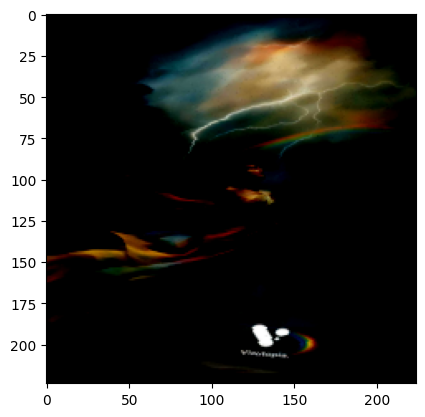

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(val_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));

print("Label: ", classes_str[labels[0]])

In [ ]:
from torch.nn import functional as F

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, output_dim)


    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [ ]:
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
criterion = nn.CrossEntropyLoss()
input_dim = 512
output_dim = 5
decoder = Decoder(input_dim, output_dim).to(device)
for param in decoder.parameters():
  param.requires_grad = True
optimizer = optim.Adam(decoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30000,60000,90000], gamma=0.3)

In [ ]:
from numpy.lib.type_check import imag
from sklearn.metrics import accuracy_score, f1_score
import torchvision.transforms as T


def train_model(model,decoder, device, train_loader, optimizer,scheduler,criterion):

  model = model.to(device)
  dcoder=decoder.to(device)
  total_loss = 0.0

  decoder.train()
  for images, targets in train_loader:
    images, targets = images.to(device),targets.float().to(device)
    with torch.no_grad():
      image_features = model.encode_image(images)
    image_features=image_features.to(torch.float32)

    outputs = decoder(image_features)

    targets=targets.to(torch.int64)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    total_loss += loss.item()

  return total_loss


def validation(model,decoder, device, val_loader,criterion):
  model = model.to(device)
  dcoder=decoder.to(device)
  decoder.eval()

  y_true_val = []
  y_pred_val = []
  y=[]
  y_pred=[]

  total_loss=0

  with torch.no_grad():
    for images, targets in val_loader:
      images = images.to(device)
      targets = targets.float().to(device)  # Convert targets to float and move to device

      with torch.no_grad():
        image_features = model.encode_image(images)
      image_features=image_features.to(torch.float32)
      outputs = decoder(image_features)

      targets=targets.to(torch.int64)
      loss = criterion(outputs, targets)

      pred = outputs.argmax(dim=1, keepdim=True)
      total_loss += loss.item()


      y_true_val.extend(targets.cpu().tolist())
      y_pred_val.extend(pred.cpu().tolist())
      y.append(y_true_val)
      y_pred.append(y_pred_val)

    y=np.array(y)
    y=np.reshape(y,(-1))
    y_pred=np.array(y_pred)
    y_pred=np.reshape(y_pred,(-1))

  accuracy=accuracy_score(y,y_pred)

  return total_loss,y,y_pred,accuracy



In [ ]:

num_epochs = 50
Acc=0

for epoch in range(num_epochs):
  total_loss=train_model(model,decoder, device, train_loader, optimizer,scheduler,criterion)
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.4f}")

  total_val_loss,target,predictions,hamming=validation(model,decoder, device, val_loader,criterion)




  print(f"Validation Loss: {total_val_loss/len(val_loader):.4f}, Validation Accuracy: {hamming*100:.4f}%")

  if Acc<hamming:
    torch.save(decoder.state_dict(), 'Seasons.pth')
    Acc=hamming
    y=target
    y_pred=predictions


Epoch [1/50], Train Loss: 0.3465
Validation Loss: 0.1229, Validation Accuracy: 95.7230%
Epoch [2/50], Train Loss: 0.1433
Validation Loss: 0.0955, Validation Accuracy: 96.7413%
Epoch [3/50], Train Loss: 0.0962
Validation Loss: 0.0567, Validation Accuracy: 97.9633%
Epoch [4/50], Train Loss: 0.0622
Validation Loss: 0.0741, Validation Accuracy: 97.5560%
Epoch [5/50], Train Loss: 0.0544
Validation Loss: 0.0550, Validation Accuracy: 97.7597%
Epoch [6/50], Train Loss: 0.0494
Validation Loss: 0.0790, Validation Accuracy: 97.3523%
Epoch [7/50], Train Loss: 0.0435
Validation Loss: 0.1068, Validation Accuracy: 96.9450%
Epoch [8/50], Train Loss: 0.0307
Validation Loss: 0.0840, Validation Accuracy: 97.1487%
Epoch [9/50], Train Loss: 0.0244
Validation Loss: 0.0465, Validation Accuracy: 97.9633%
Epoch [10/50], Train Loss: 0.0363
Validation Loss: 0.0526, Validation Accuracy: 97.9633%
Epoch [11/50], Train Loss: 0.0279
Validation Loss: 0.0933, Validation Accuracy: 97.7597%
Epoch [12/50], Train Loss: 0.0

In [ ]:
from sklearn.metrics import classification_report
print(f'Best Accuracy score: {Acc*100:.2f}% \n\n')


print(classification_report(y, y_pred,target_names=classes_str,zero_division=0))


Best Accuracy score: 99.39% 


                    precision    recall  f1-score   support

            autumn       1.00      1.00      1.00      3015
natural-phenomenon       0.98      0.98      0.98      2520
   northern-lights       1.00      1.00      1.00       720
            stormy       0.99      0.99      0.99      6705
            winter       1.00      1.00      1.00      9135

          accuracy                           0.99     22095
         macro avg       0.99      0.99      0.99     22095
      weighted avg       0.99      0.99      0.99     22095



Actual Tags: natural-phenomenon
Predicted Tags: ['natural-phenomenon']


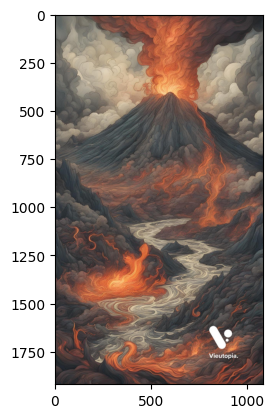

In [ ]:
from itertools import chain
import random
import torchvision
from torchvision import models, transforms

def test_one_image(i):
  image_path='/content/seasons/'+val_files[i]
  image_class= val_target[i]

  transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match model's input size
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
  ])

  decoder=Decoder(input_dim, output_dim).to(device)
  decoder.load_state_dict(torch.load('Seasons.pth', map_location=device))
  image = Image.open(image_path)
  image = transform(image)
  image = image.unsqueeze(0)
  image=image.to(device)
  decoder.eval()
  with torch.no_grad():
    image_features = model.encode_image(image)
  image_features=image_features.to(torch.float32)
  outputs = decoder(image_features)
  pred = outputs.argmax(dim=1, keepdim=True)
  pred = pred.cpu().tolist()
  pred=list(chain.from_iterable(pred))
  actual_tag=classes_str[image_class]
  predicted_tag=classes_str[pred]

  print(f'Actual Tags: {actual_tag}\nPredicted Tags: {predicted_tag}')


  image = Image.open(image_path)
  plt.imshow(image)


test_one_image(4)

Actual Tags: autumn
Predicted Tags: ['autumn']


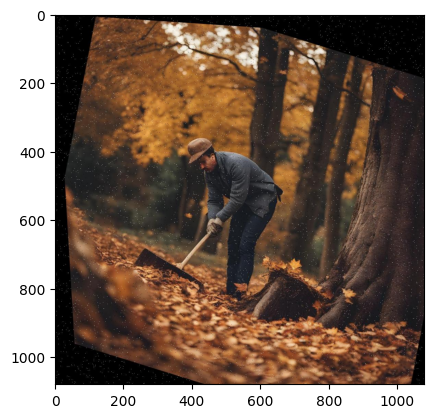

In [ ]:
test_one_image(8)

Actual Tags: winter
Predicted Tags: ['winter']


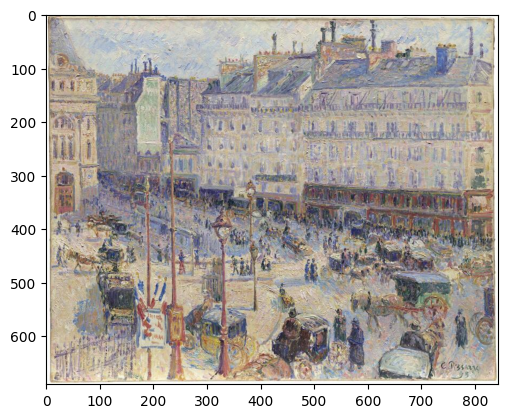

In [ ]:
test_one_image(12)

Actual Tags: stormy
Predicted Tags: ['stormy']


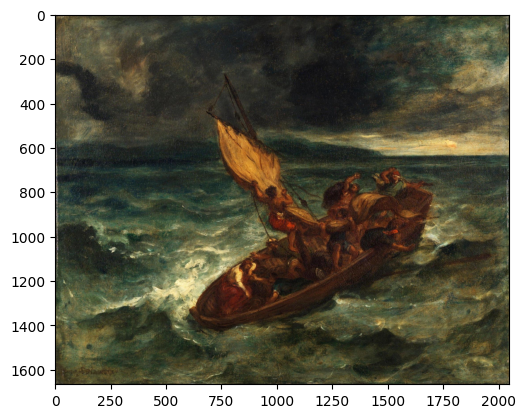

In [ ]:
test_one_image(13)

Actual Tags: autumn
Predicted Tags: ['autumn']


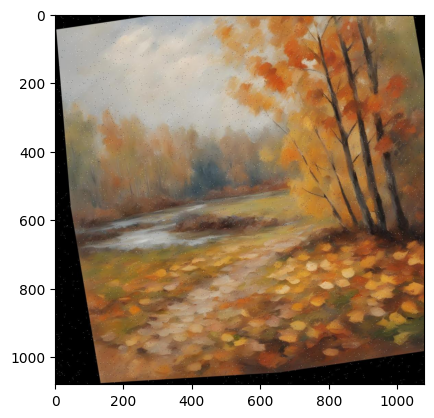

In [ ]:
test_one_image(17)

Actual Tags: winter
Predicted Tags: ['stormy']


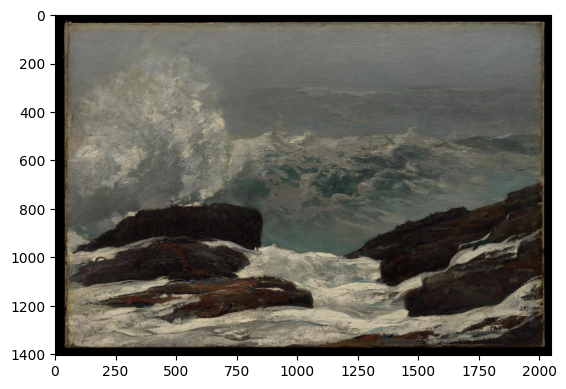

In [ ]:
test_one_image(22)

Actual Tags: autumn
Predicted Tags: ['autumn']


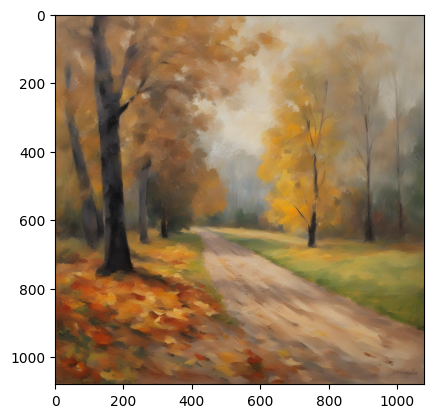

In [ ]:
test_one_image(24)